In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.models import Sequential
import pathlib

Foto's inladen

In [ ]:
from google.colab import drive
from PIL import Image

drive.mount('/content/gdrive')
data_dir = "/content/gdrive/My Drive/NB/Train"


Mounted at /content/gdrive


Foto's formaat opgeven

In [ ]:
img_height = 275
img_width = 275
batch_size = 16

image_size = (img_height, img_width)

Data split (Train data)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

train_label = train_ds.class_names
print(train_ds)

Found 378 files belonging to 4 classes.
Using 303 files for training.
<BatchDataset element_spec=(TensorSpec(shape=(None, 275, 275, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Data split(Validation data)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_label = val_ds.class_names

Found 378 files belonging to 4 classes.
Using 75 files for validation.


Visualiseren van data

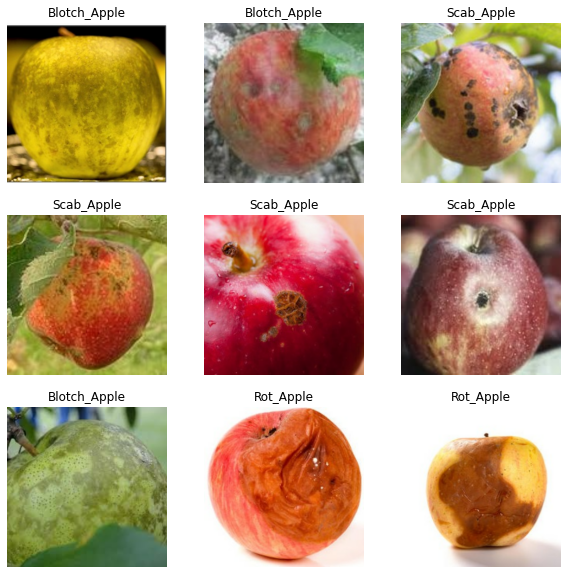

In [ ]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 275, 275, 3)
(16,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Data normaliseren

In [ ]:
import numpy as np
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Data augmentation 

In [ ]:
layers_RandomTranslation = tf.keras.layers.RandomTranslation(
    height_factor=(0.2),
    width_factor = 0.2,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0,
)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomRotation(0.2),
    layers.RandomRotation(0.3),
    layers.RandomRotation(0.4),
    layers.RandomRotation(0.5),
    layers.RandomRotation(0.6),
    layers.RandomRotation(0.7),
    layers.RandomRotation(0.8),
    layers.RandomRotation(0.9),
    layers.RandomRotation(1),
   
    layers.RandomZoom(0.1),
    layers.RandomZoom(0.14),
    layers.RandomZoom(0.17),
    layers.RandomZoom(0.19),
   
    layers.RandomContrast(factor=0.1, seed=None),
    layers.RandomContrast(factor=0.2, seed=None),
    layers.RandomContrast(factor=0.3, seed=None),
    layers.RandomContrast(factor=0.4, seed=None),
    layers.RandomContrast(factor=0.5, seed=None),
    # layers.RandomContrast(factor=0.6, seed=None),

    layers.RandomBrightness(factor=0.1),
    layers.RandomBrightness(factor=0.2),
    layers.RandomBrightness(factor=0.3),
    layers.RandomBrightness(factor=0.4),
    # layers.RandomBrightness(factor=0.5),
    # layers.RandomBrightness(factor=0.6),
   
    layers_RandomTranslation

  ]
)

Data augmentation visualiseren

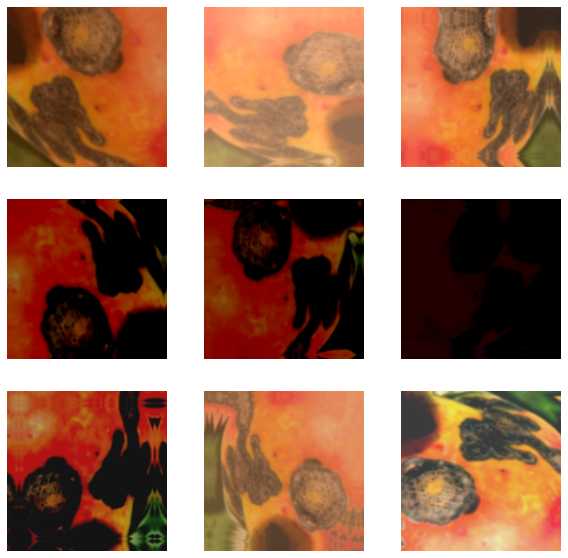

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Model maken

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
  # layers.Dense(1, activation="sigmoid")
])

Transfer Learning (Resnet)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (275,275,3))
for layer in base_model.layers:
  layer.trainable = False


234698864/234698864 [==============================] - 16s 0us/step


Top Layer Toevoegen

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(10000, activation='relu')(x)
predictions = layers.Dense(num_classes, activation = 'softmax')(x)


Model compile - sparse_categorical_crossentropy

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.580944 to fit



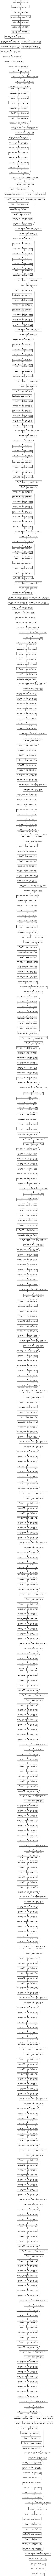

In [ ]:

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = keras.optimizers.Adam(learning_rate=0.00001)
head_model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
keras.utils.plot_model(head_model, show_shapes=True)

Model training Epochs

In [ ]:

history = head_model.fit(train_ds, batch_size=32, epochs=15, validation_data=(val_ds))



Epoch 1/15


KeyboardInterrupt: ignored

Model Plot

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

Test data confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

test_data_dir = "/content/gdrive/My Drive/NB/Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    shuffle = False,
    batch_size=batch_size)

scores = head_model.evaluate(test_ds)

batchPredictions = head_model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple'])


cm_display.plot()
plt.show()

head_model.evaluate(test_ds)

Model opslaan

In [ ]:
# head_model.save('/content/gdrive/My Drive/new_model')

In [ ]:
link = "https://d31n3wj3oi4lt9.cloudfront.net/wp-content/uploads/sites/36/2021/08/Figure-2-768x1024.jpg"
image_url = f"{link}"
ind_link = link.rfind('/') +1


url_str = image_url[ind_link:(len(image_url))]


image_path = tf.keras.utils.get_file(url_str, origin=link)

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = head_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
!ls /content/gdrive/MyDrive/NB/batch

test_data_dir = "/content/gdrive/MyDrive/NB/batch"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    shuffle = False,
    batch_size=batch_size)

scores = head_model.evaluate(test_ds)

batchPredictions = head_model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple'])


cm_display.plot()
plt.show()

head_model.evaluate(test_ds)